In [212]:

## Code adapted from relataly.com example by Florian Müller:
## https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/ 


# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler


from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score




#keep these handy
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



df = pd.read_csv('engineered.csv')

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shortdate           66 non-null     object 
 1   Close               66 non-null     float64
 2   Diff                66 non-null     float64
 3   next_day_close      66 non-null     float64
 4   next_day_diff       66 non-null     float64
 5   next_day_plus_diff  66 non-null     int64  
 6   plus_diff           66 non-null     int64  
 7   comment_count       66 non-null     int64  
 8   rocket              66 non-null     int64  
 9   gem                 66 non-null     int64  
 10  clown               66 non-null     int64  
 11  joy                 66 non-null     int64  
 12  hands               66 non-null     int64  
 13  bear                66 non-null     int64  
 14  gorilla             66 non-null     int64  
 15  money_face          66 non-null     int64  
 16  rofl      

In [214]:
df = df.set_index('shortdate') 

In [215]:
print(df.index)

Index(['2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-27',
       '2021-01-28', '2021-01-29', '2021-02-01', '2021-02-02', '2021-02-03',
       '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-16',
       '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
       '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-02', '2021-03-03',
       '2021-03-04', '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10',
       '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17',
       '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-05', '2021-04-06',
       '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-14', '2021-04-15',
       '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
       '2021-04-23', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
       '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
       '2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',

In [216]:



# Indexing Batches
train_df = df.sort_values(by=['shortdate']).copy()

# We save a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Close,Diff,next_day_close,next_day_diff,next_day_plus_diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,Month,Year
0,844.549988,6.750000,850.450012,-8.289978,0,1,1402,73,12,2,8,10,12,0,1,2,12,0,3,2,9,1,2,1,3,0,0,2,12,10,2,0,0,18,6,13,0,2,4,2,1,1,01,2021
1,850.450012,-8.289978,844.989990,-10.010010,0,0,1459,91,7,7,7,0,8,0,2,0,10,1,3,4,2,0,5,4,7,0,2,6,8,16,3,0,2,16,4,15,1,2,0,2,1,0,01,2021
2,844.989990,-10.010010,846.640015,12.330017,1,0,1478,99,15,8,12,3,12,0,4,2,7,0,1,5,4,2,3,2,4,2,3,9,12,17,4,0,1,13,8,14,1,3,0,0,0,1,01,2021
3,846.640015,12.330017,880.799988,25.799988,1,1,1684,96,33,5,9,15,10,1,0,3,10,2,2,4,7,2,2,2,9,1,2,5,21,26,1,0,2,26,8,18,0,1,8,3,1,2,01,2021
4,864.159973,-6.190002,835.429993,15.429993,1,0,1829,112,34,3,7,11,6,1,7,4,7,4,6,10,5,1,5,1,2,1,3,2,6,11,2,0,3,36,10,18,1,0,2,2,0,1,01,2021


In [217]:
date_index

Index(['2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-27',
       '2021-01-28', '2021-01-29', '2021-02-01', '2021-02-02', '2021-02-03',
       '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-16',
       '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
       '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-02', '2021-03-03',
       '2021-03-04', '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10',
       '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17',
       '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-05', '2021-04-06',
       '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-14', '2021-04-15',
       '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
       '2021-04-23', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
       '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
       '2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',

In [218]:
# List of considered Features
FEATURES = ['Close','Diff','plus_diff','comment_count','rocket','gem','clown','joy','hands','bear','gorilla','money_face','rofl','rainbow','flex','cry','think','smile','fire','eyes','upchart','pray','downchart','mbag','FD','DD','YOLO','ATH','HODL','DFV','MOON','STONKS','TENDIES','GAYBEARS','BAGHOLDER','DIAMONDHANDS','PAPERHANDS','JPOW','DEGENERATES']

print('FEATURE LIST')
print([f for f in FEATURES]) 

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'Diff', 'plus_diff', 'comment_count', 'rocket', 'gem', 'clown', 'joy', 'hands', 'bear', 'gorilla', 'money_face', 'rofl', 'rainbow', 'flex', 'cry', 'think', 'smile', 'fire', 'eyes', 'upchart', 'pray', 'downchart', 'mbag', 'FD', 'DD', 'YOLO', 'ATH', 'HODL', 'DFV', 'MOON', 'STONKS', 'TENDIES', 'GAYBEARS', 'BAGHOLDER', 'DIAMONDHANDS', 'PAPERHANDS', 'JPOW', 'DEGENERATES']


,Close,Diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,Prediction
61,629.039978,-35.860046,0,802,6,0,7,11,0,3,0,1,3,3,1,2,1,1,2,1,1,0,0,0,0,5,7,1,0,1,3,3,2,1,3,0,0,0,0,629.039978
62,617.200012,17.960022,1,920,5,0,14,4,0,1,0,4,2,0,0,5,2,1,0,1,0,1,1,0,5,2,10,0,0,0,2,3,3,1,4,1,3,0,1,617.200012
63,589.890015,-12.599976,0,830,4,1,17,2,1,5,1,1,2,2,1,0,3,1,0,1,2,1,2,0,7,1,5,4,0,0,7,1,0,0,2,1,0,0,0,589.890015
64,571.690002,-29.849976,0,1403,10,2,18,16,1,4,0,1,3,2,3,1,4,3,3,2,0,0,1,1,5,7,8,4,0,0,6,1,1,3,5,1,0,0,0,571.690002
65,589.739990,6.330017,1,925,18,1,8,7,0,0,2,1,1,0,0,4,3,1,1,0,0,1,1,1,7,3,2,2,0,1,1,0,2,1,0,0,1,2,0,589.739990


In [219]:

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(66, 39)


In [220]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 40 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[0:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(13, 40, 1) (13,)
(13, 40, 1) (13,)
0.34852635127400733
0.34852635127400733


In [221]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

40 40 1


In [222]:
# Training the model
epochs = 30
batch_size = 10
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/30
2/2 [==============================] - 4s 2s/step - loss: 0.2383 - val_loss: 0.0385
Epoch 2/30
2/2 [==============================] - 0s 32ms/step - loss: 0.1375 - val_loss: 0.0158
Epoch 3/30
2/2 [==============================] - 0s 30ms/step - loss: 0.0587 - val_loss: 0.0373
Epoch 4/30
2/2 [==============================] - 0s 26ms/step - loss: 0.0137 - val_loss: 0.1241
Epoch 5/30
2/2 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.2128
Epoch 6/30
2/2 [==============================] - 0s 26ms/step - loss: 0.0360 - val_loss: 0.1996
Epoch 7/30
2/2 [==============================] - 0s 27ms/step - loss: 0.0299 - val_loss: 0.1420
Epoch 8/30
2/2 [==============================] - 0s 31ms/step - loss: 0.0138 - val_loss: 0.0964
Epoch 9/30
2/2 [==============================] - 0s 29ms/step - loss: 0.0063 - val_loss: 0.0690
Epoch 10/30
2/2 [==============================] - 0s 27ms/step - loss: 0.0060 - val_loss: 0.0549
Epoch 11/30
2/2 [==============

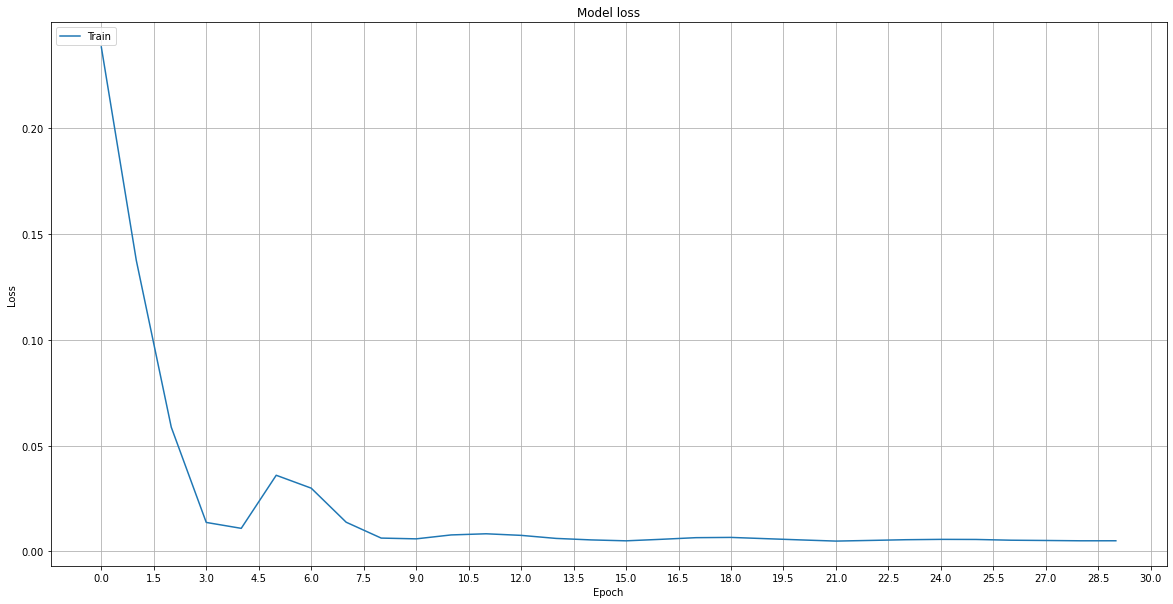

In [223]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [224]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 77.91
Mean Absolute Percentage Error (MAPE): 12.4 %
Median Absolute Percentage Error (MDAPE): 9.33 %


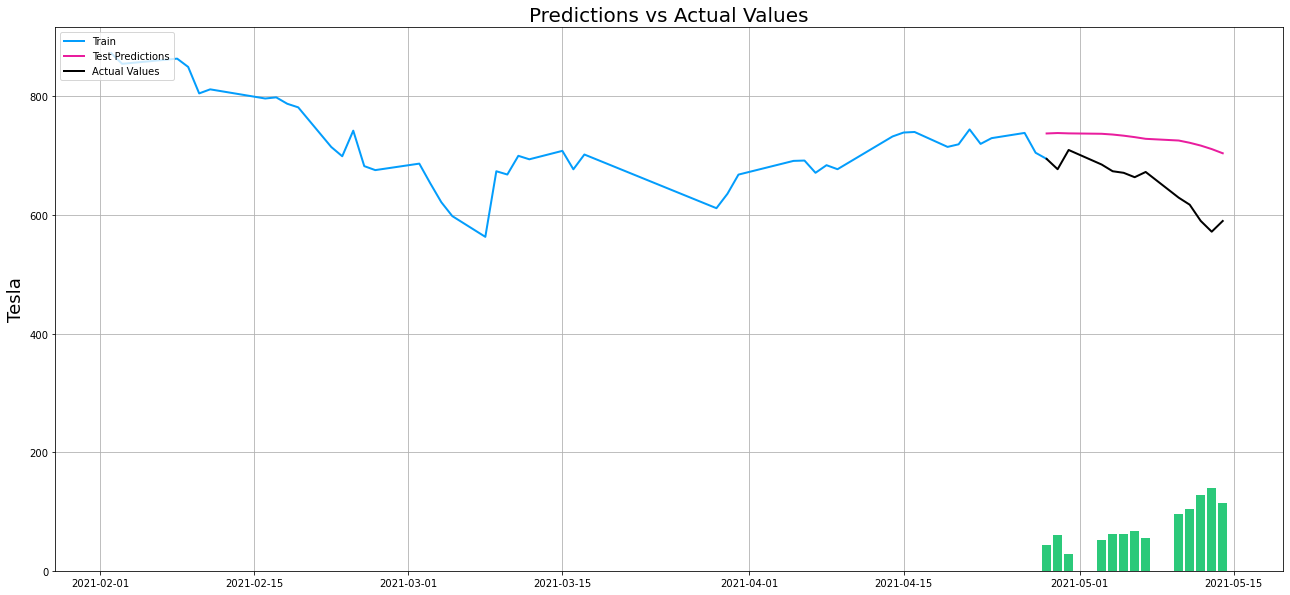

In [225]:
stockname = 'Tesla'
symbol = '^TSLA'



# The start date 

display_start_date = pd.Timestamp(2021,2,1)


# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = pd.to_datetime(date_index, format='%Y-%m-%d')



# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [226]:
#import shap 
#explainer = shap.KernelExplainer(model.predict,x_train)
#shap_values = explainer.shap_values(x_test,nsamples=59)

#getting errors trying to run Shap for LTSM - see some commentary that interpretation is problematic for ML


In [227]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [228]:
## Code adapted from example by Rahul Sagrolikar:


def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')


In [229]:
#Refit for XGBOOST
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [230]:
X = train_df.drop(['next_day_close','next_day_diff','next_day_plus_diff','Month','Year'], axis= 1)
Y = train_df['next_day_plus_diff']

In [231]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


X_test=X_test[X_train.columns]

In [232]:
final_df, final_vif = iterate_vif(X_train)

Iteration # 1
Removing comment_count with VIF of 485.937618
Iteration # 2
Removing hands with VIF of 193.988022
Iteration # 3
Removing rainbow with VIF of 173.791559
Iteration # 4
Removing gem with VIF of 89.659738
Iteration # 5
Removing rocket with VIF of 85.042657
Iteration # 6
Removing TENDIES with VIF of 36.720012
Iteration # 7
Removing bear with VIF of 34.333789
Iteration # 8
Removing MOON with VIF of 28.157605
Iteration # 9
Removing YOLO with VIF of 25.214173
Iteration # 10
Removing STONKS with VIF of 20.477963
Iteration # 11
Removing DIAMONDHANDS with VIF of 13.564210
Iteration # 12
Removing Close with VIF of 12.863176
Iteration # 13
Removing rofl with VIF of 12.599756
Iteration # 14
Removing DD with VIF of 11.952423
Iteration # 15
Removing clown with VIF of 10.037610
Iteration # 16
Removing think with VIF of 8.228168
Iteration # 17
Removing FD with VIF of 7.884281
Iteration # 18
Removing DFV with VIF of 6.141112
Iteration # 19
Removing PAPERHANDS with VIF of 5.769196
Iteration 

In [233]:
X_train = final_df
X_test=X_test[X_train.columns] 


In [234]:



# fit model to training data
model = XGBClassifier()


param_grid = {'learning_rate': [0.01,0.007,0.005,0.002,0.001], 
              'max_depth': [2,3,4,5,6],
              'seed': [2,3,4,5]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)




Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.2s


[13:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nan
{'learning_rate': 0.001, 'max_depth': 3, 'seed': 2}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.3s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
invalid value encountered in sqrt


In [235]:
xgb1=XGBClassifier(learning_rate = 0.001, max_depth = 3, seed = 2)
xgb1.fit(X_train, y_train.values.ravel())



[13:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [236]:
pred = xgb1.predict(X_test)

In [237]:
pred

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [238]:
pred.shape

(14,)

In [239]:
print("Accuracy for XGB Classifier on CV data: ",accuracy_score(y_test,pred))

Accuracy for XGB Classifier on CV data:  0.35714285714285715


In [240]:
print ('ROC AUC Score',roc_auc_score(y_test,pred))

ROC AUC Score 0.3571428571428571


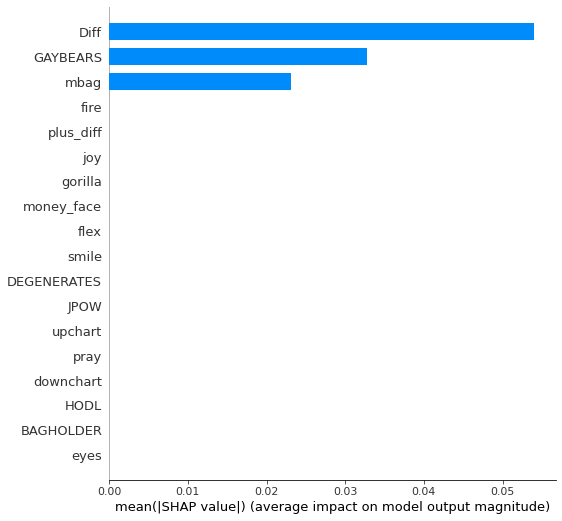

In [241]:
import shap 
shap_values = shap.TreeExplainer(xgb1).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [242]:
y_test

27    1
2     1
41    0
58    0
18    1
51    0
53    0
17    0
33    1
48    0
31    1
15    1
21    0
36    1
Name: next_day_plus_diff, dtype: int64